In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from evaluation.evaluation_harness import OnlineEvaluator, include_coldstart, include_all, score_time_spent, score_constant
from pprint import pprint


Not enough samples to get percentile figure.
{'top_10_hit_percentage': 0.2222222222222222,
 'top_10_hit_percentage_user_percentiles_figure': None,
 'user_rank_auc_roc': 0.8125,
 'user_rank_roc_figure': <Figure size 640x480 with 1 Axes>}



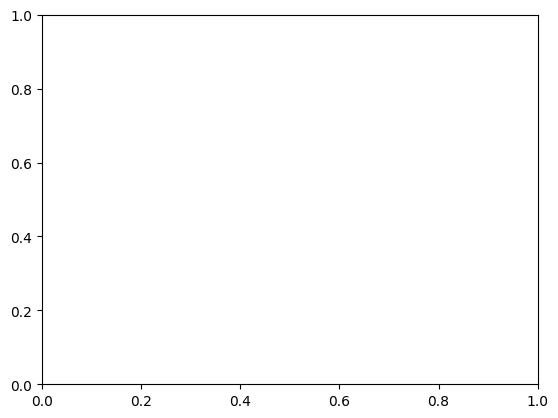

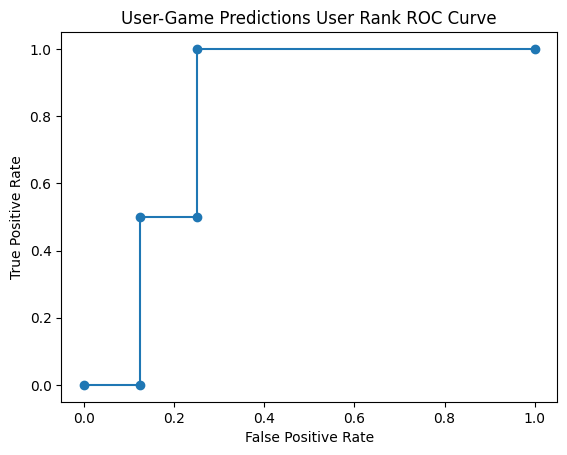

In [2]:
evaluator = OnlineEvaluator(include_all, score_constant)
evaluator.reset('common_neighbors', 'test_common_neighbors_default')
evaluator.plot_top_N_hit_percentage_percentiles(10)
evaluator.compute_top_N_hit_percentage(10)
evaluator.plot_user_rank_roc_curve()
evaluator.compute_user_rank_auc_roc()
# evaluator.save_metrics('test_online_evaluator', overwrite=True)
pprint(evaluator.metrics)
print()